# Project: Wrangling and Analyzing WeRateDogs® Twitter Archive

## Table of Contents
<ul>
   <li><a href="#intro">Introduction</a></li> 
<li><a href="#gather">Data Gathering</a></li>
<li><a href="#assess">Assessing Data</a></li>
<li><a href="#clean">Cleaning Data</a></li>
<li><a href="#analysis">Analyzing and Visualizing Data</a></li>
    <li><a href="#insights">Insights</a></li>
    <li><a href="#wranglereport">Wrangle Report</a></li>
</ul>

<a id='intro'></a>
## Introduction

The aim of this project is to wrangle and analyze data. The data used in this analysis is the tweet archive of a user, [WeRateDogs®](https://twitter.com/dog_rates), from 15th November 2015 to 1st August 2017. WeRateDogs is a Twitter account that rates dogs with a humorous comment about the dog. The data used is spread across different sources. The data included WeRateDogs twitter archive given by Udacity as a [csv file](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv), a tsv file hosted on Udacity servers containing image predictions for each tweet ID and additional data on the tweets which I accessed using the Twitter API.

The goal of this project is to gather and clean the data from the three sources as they contain some quality and tidiness issues and combine these into a master pandas DataFrame. I intend to then analyze this master DataFrame and derive insights from the data.

In some instances, I viewed the tweets on Twitter using the tweet's ID by appending the ID to https://twitter.com/i/web/status/

**NB:** A summarized report of my data gathering, assessing and cleaning efforts can be found at the end of the note. Clicking on `Wrangle Report` in the table to contents skips to that part.

### Importing modules

In [1]:
import copy
import json
import os
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import tweepy
from tweepy import OAuthHandler

<a id='gather'></a>
##  Data Gathering

##### Importing first file (csv file)

In [2]:
# reading csv file into a dataframe
df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# displaying first 5 rows of the dataframe
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


##### Downloading second file using the Requests library

In [4]:
# creating a folder
directory_name = 'tsv_file'
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

In [5]:
# using the Requests library to get the contents of the url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [6]:
# writing the contents of the url to a file
with open(os.path.join(directory_name,url.split('/')[-1]),mode='wb') as file:
    file.write(response.content)

In [7]:
# reading the tsv file into a dataframe
df_02 = pd.read_csv('tsv_file/image-predictions.tsv',sep = '\t')

In [8]:
# displaying first rows of the dataframe
df_02.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### Getting third file from Twitter using the Tweepy library

In [9]:
# the keys are hidden to comply with Twitter rules
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# assigning tweet Ids in df to a variable
tweet_ids = df.tweet_id.values
len(tweet_ids)

# creating dictionary to which erroes will be appended
fails_dict = {}
start = timer()
# Saving each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # loop to get each tweet's json data
    for tweet_id in tweet_ids:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except Exception as e:
            fails_dict[tweet_id] = e
            pass
end = timer()
# printing time it took to run
print(end - start)
# printing the number of errors
print(len(fails_dict))

3948.1561274
29


It took 66 mins to run and 29 tweet IDs were not retrieved

In [10]:
# reading the json contents stored in the txt file to  a DataFrame
with open('tweet_json.txt') as f:
    data = [json.loads(line) for line in f ]

json_df = pd.DataFrame(data)
json_df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN


In [11]:
# creating new DataFrame using relevant columns from json_df
df_03 = json_df[['id','retweet_count','favorite_count']].copy()

In [12]:
# displaying a sample of the DataFrame 
df_03.sample(10)

,id,retweet_count,favorite_count
1158,718540630683709445,920,2241
1210,712097430750289920,930,3448
1214,711998809858043904,120,0
1131,724046343203856385,512,2449
914,752917284578922496,1436,6482
1790,676590572941893632,110,834
1294,706291001778950144,434,1565
1579,685663452032069632,1328,2967
1193,714485234495041536,1007,2444
1318,704480331685040129,977,3140


<a id='assess'></a>
## Assessing Data

##### df

In [13]:
df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2108,670452855871037440,NaN,NaN,2015-11-28 04:03:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog can't see its haters. 11/10 https://t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670452855...,11,10,None,None,None,None,None
1184,718631497683582976,NaN,NaN,2016-04-09 02:47:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We normally don't rate marshmallows but this o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718631497...,10,10,None,None,None,None,None
828,768970937022709760,NaN,NaN,2016-08-26 00:38:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is Kirby. His bowl weighs more than him. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/768970937...,12,10,Kirby,None,None,None,None
1784,677662372920729601,NaN,NaN,2015-12-18 01:31:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",In honor of the new Star Wars movie. Here's Yo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677662372...,12,10,None,None,None,None,None
770,776819012571455488,NaN,NaN,2016-09-16 16:24:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everybody look at this beautifu...,6.798284e+17,4.196984e+09,2015-12-24 00:58:27 +0000,https://twitter.com/dog_rates/status/679828447...,13,10,None,None,None,pupper,None
718,783466772167098368,NaN,NaN,2016-10-05 00:40:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Finn. He likes eavesdropping from fili...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/783466772...,11,10,Finn,None,None,None,None
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
984,749317047558017024,NaN,NaN,2016-07-02 19:01:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Blu. He's a wild bush Floofer. I wish ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749317047...,12,10,Blu,None,floofer,None,None
280,839549326359670784,NaN,NaN,2017-03-08 18:52:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He knows he's a little too big f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/839549326...,12,10,Winston,None,None,None,None
2133,670073503555706880,NaN,NaN,2015-11-27 02:55:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He wants to be a power drill. Ve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670073503...,10,10,Winston,None,None,None,None


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
# checking for double dog stages
df[(df['doggo'] != "None") & (df['floofer'] != "None")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None


* index 200 - Two dog stages were extracted from the tweet because two dog stages were mentioned but it is only one dog and the stage is `floofer` therefore `doggo` needs to be replaced with `None`.

In [16]:
df[(df['doggo'] != "None") & (df['pupper'] != "None")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,doggo,None,pupper,None
956,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751583847...,5,10,None,doggo,None,pupper,None


* index 460 - dog stage is actually `pupper` therefore `doggo` has to be replaced with `None`
* index 575 - dog is actually a `pupper` therefore `doggo` has to be replaced with `None`
* index 705 - even though the animal is not a dog it's given stage was `doggo` not `pupper`
* index 956 - even though two dog stages were mentioned, none applies to the dog

NB: for indexes that were not mentioned, there were two dogs in the tweet hence the double stages

In [17]:
df[(df['doggo'] != "None") & (df['puppo'] != "None")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo


* index 191 - dog stage is `puppo` even though `doggo` was mentioned in the tweet

In [18]:
df[(df['floofer'] != "None") & (df['pupper'] != "None")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


No tweets with both `floofer` and `pupper` stages

In [19]:
df[(df['floofer'] != "None") & (df['puppo'] != "None")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


No tweets with `floofer` and `puppo` stages

In [20]:
df[(df['pupper'] != "None") & (df['puppo'] != "None")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


No tweets with `pupper` and `puppo` stages

In [21]:
# checking the distribution of numbers in the `rating_denominators` column
df.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

The rating denominator is almost always 10 and as the ratings were extracted from the text so I will display the text of tweets where the denominator is not 10 to and identify any problems with the ratings extraction 

In [22]:
df.query('rating_denominator == 11').text.tolist()

['RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…',
 'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ',
 'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5']

In [23]:
df.query('rating_denominator == 11').index

Int64Index([784, 1068, 1662], dtype='int64')

* index 784 is a retweet of the tweet ID in index 1068 and must be dropped
* index 1068 - rating numerator is actually 14 and denominator is 10 
* index 1662 - rating numerator is actually 10 and denominator is 10

In [24]:
df.query('rating_denominator == 50').text.tolist()

['This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq',
 'From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK',
 "Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa"]

In [25]:
df.query('rating_denominator == 50').index

Int64Index([1202, 1274, 1351], dtype='int64')

* Index 1202 - the actual rating is 11/10 not 50/50 
* In the second and third indexes, the ratings were given to a group of dogs

In [26]:
df.query('rating_denominator == 20').text.tolist()

['Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a',
 "Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating"]

In [27]:
df.query('rating_denominator == 20').index

Int64Index([1165, 1598], dtype='int64')

* Index 1165 - the rating is actually 13/10
* Index 1598 - the tweet is a reply and not an actual rating

In [28]:
df.query('rating_denominator == 80').text.tolist()

["Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12",
 'Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw']

For both instances, the ratings were given to a group of dogs

In [29]:
df.query('rating_denominator == 70').text.tolist()

['The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd']

Rating was for a group of dogs

In [30]:
df.query('rating_denominator == 7').text.tolist()

['Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx']

In [31]:
df.query('rating_denominator == 7').index

Int64Index([516], dtype='int64')

* index 516 - 24/7 is not a rating and there was no given rating in the tweet.

In [32]:
df.query('rating_denominator == 15').text.tolist()

['@docmisterio account started on 11/15/15']

In [33]:
df.query('rating_denominator == 15').index

Int64Index([342], dtype='int64')

* index 342 - tweet was a reply to another user and not a dog rating

In [34]:
df.query('rating_denominator == 150').text.tolist()

['Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE']

rating was for a group of dogs

In [35]:
df.query('rating_denominator == 170').text.tolist()

['Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv']

rating was for a group of dogs

In [36]:
df.query('rating_denominator == 0').text.tolist()

["@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"]

In [37]:
df.query('rating_denominator == 0').index

Int64Index([313], dtype='int64')

* index 313 - This is a reply to another user and not an actual dog rating

In [38]:
df.query('rating_denominator == 90').text.tolist()

["Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1"]

rating is for a group of dogs

In [39]:
df.query('rating_denominator == 40').text.tolist()

["Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ"]

Rating is for a group of dogs

In [40]:
df.query('rating_denominator == 130').text.tolist()

['Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3']

After checking the tweet on Twitter, I realized the initial rating was 121/110 but WeRateDogs changed the rating to 143/130.

In [41]:
df.query('rating_denominator == 110').text.tolist()

['Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55']

In [42]:
df.query('rating_denominator == 110').index

Int64Index([1635], dtype='int64')

* index 1635 - This is the tweet where the initial rating was 121/110 but changed to 143/130

In [43]:
df.query('rating_denominator == 16').text.tolist()

["I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible"]

In [44]:
df.query('rating_denominator == 16').index

Int64Index([1663], dtype='int64')

* index 1663 - After viewing the tweet on Twitter, I discovered that it was not a dog rating.

In [45]:
df.query('rating_denominator == 120').text.tolist()

["IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq"]

Rating was for a group of dogs

In [46]:
df.query('rating_denominator == 2').text.tolist()

['This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv']

In [47]:
df.query('rating_denominator == 2').index

Int64Index([2335], dtype='int64')

* index 2335 - The actual rating is 9/10

In [48]:
# checking the distribution of numbers in the `rating_numerator` column
df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

Because some of the ratings were given only once, I decided to investigate those ratings to see if they were the correct ratings or had been extracted wrongly. Where there were no issues with the rating, I did not comment but where i discovered an issue with the rating, I commented below noting the index to be used to correct the issue.

In [49]:
df.query('rating_numerator == 88').text.tolist()

['Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw']

In [50]:
df.query('rating_numerator == 84').text.tolist()

['The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd']

In [51]:
df.query('rating_numerator == 960').text.tolist()

["@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"]

Tweet is not a rating but issue has already been discovered under `rating_denominator` value counts

In [52]:
df.query('rating_numerator == 24').text.tolist()

['Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx']

24/7 is not the rating but issue has already been discovered in `rating_denominator` value counts 

In [53]:
df.query('rating_numerator == 182').text.tolist()

['@markhoppus 182/10']

In [54]:
df.query('rating_numerator == 27').text.tolist()

["This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq"]

In [55]:
df.query('rating_numerator == 27').index

Int64Index([763], dtype='int64')

* index 763 - correct rating is 11.27/10 not 27/10

In [56]:
df.query('rating_numerator == 666').text.tolist()

['@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10']

In [57]:
df.query('rating_numerator == 165').text.tolist()

['Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE']

In [58]:
df.query('rating_numerator == 1776').text.tolist()

["This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"]

In [59]:
df.query('rating_numerator == 204').text.tolist()

['Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv']

In [60]:
df.query('rating_numerator == 99').text.tolist()

["Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1"]

In [61]:
df.query('rating_numerator == 50').text.tolist()

['This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq']

Actual rating is 11/10 not 50/50 but issue has already been discovered under rating_denominator

In [62]:
df.query('rating_numerator == 45').text.tolist()

['From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK']

In [63]:
df.query('rating_numerator == 60').text.tolist()

["Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa"]

In [64]:
df.query('rating_numerator == 44').text.tolist()

["Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ"]

In [65]:
df.query('rating_numerator == 143').text.tolist()

['Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3']

In [66]:
df.query('rating_numerator == 121').text.tolist()

['Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55']

In [67]:
df.query('rating_numerator == 20').text.tolist()

["I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible"]

In [68]:
df.query('rating_numerator == 26').text.tolist()

['Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']

In [69]:
df.query('rating_numerator == 26').index

Int64Index([1712], dtype='int64')

* index 1712 - correct rating is 11.26/10 not 26/10

In [70]:
df.query('rating_numerator == 17').text.tolist()

['@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s']

In [71]:
df.query('rating_numerator == 17').index

Int64Index([55], dtype='int64')

* index 55 - rating is 13/10 not 17/10

In [72]:
df.query('rating_numerator == 144').text.tolist()

["IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq"]

In [73]:
df.query('rating_numerator == 80').text.tolist()

["Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12"]

In [74]:
df.query('rating_numerator == 0').text.tolist()

["When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag",
 "PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX"]

In [75]:
df.query('rating_numerator == 420').text.tolist()

['@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research',
 'After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY']

In [76]:
df.query('rating_numerator == 420').index

Int64Index([188, 2074], dtype='int64')

* index 188 is a reply and not an actual rating but a mention of the rating in index 2074 therefore must be dropped

In [77]:
df.query('rating_numerator == 15').text.tolist()

['RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI',
 '@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10']

In [78]:
df.query('rating_numerator == 75').text.tolist()

["RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",
 "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"]

In [79]:
df.query('rating_numerator == 75').index

Int64Index([340, 695], dtype='int64')

* index 340 and 695 - rating is actually 9.75/10 not 75/10 as extracted

In [80]:
df.query('rating_numerator == 1').text.tolist()

["RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…",
 'After reading the comments I may have overestimated this pup. Downgraded to a 1/10. Please forgive me',
 "What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0",
 "The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you",
 'After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes',
 "Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO",
 'Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx',
 'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the co

In the 8th text, the rating is 9/10 not 1/2 but issue was discovered under rating_denominator vlaue counts

In [81]:
df.query('rating_numerator == 2').text.tolist()

['Exotic pup here. Tail long af. Throat looks swollen. Might breathe fire. Exceptionally unfluffy 2/10 would still pet https://t.co/a8SqCaSo2r',
 "This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible https://t.co/rtMtjSl9pz",
 "This is Henry. He's a shit dog. Short pointy ears. Leaves trail of pee. Not fluffy. Doesn't come when called. 2/10 https://t.co/Pu9RhfHDEQ",
 "Scary dog here. Too many legs. Extra tail. Not soft, let alone fluffy. Won't bark. Moves sideways. Has weapon. 2/10 https://t.co/XOPXCSXiUT",
 "This lil pup is Oliver. Hops around. Has wings but doesn't fly (lame). Annoying chirp. Won't catch tennis balls 2/10 https://t.co/DnhUw0aBM2",
 "This is Tedrick. He lives on the edge. Needs someone to hit the gas tho. Other than that he's a baller. 10&amp;2/10 https://t.co/LvP1TTYSCN",
 "Unfamiliar with this breed. Ears pointy af. Won't let go of seashell. Won't eat kibble. Not very fast. Bad dog 2/10 https://t.co/EIn

In [82]:
df.query('rating_numerator == 4').text.tolist()

['This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP',
 "Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl",
 'Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R',
 'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a',
 "This is Benedict. He's a feisty pup. Needs a brushing. Portable af. Looks very angry actually. 4/10 might not pet https://t.co/3oeFfHjv0Z",
 "This is Keurig. He's a rare dog. Laughs like an idiot tho. Head is basically a weapon. Poorly maintained goatee 4/10 https://t.co/xOrUyj7K30",
 "This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",
 "Yes I do realize a rating of 4/20 would've been fitting. However, 

In [83]:
df.query('rating_numerator == 3').text.tolist()

["This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M",
 "This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target https://t.co/FmxOpf2Sgl",
 "What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair https://t.co/wcwoGOkZvz",
 "This is Elliot. He's blocking the roadway. Downright rude as hell. Doesn't care that you're already late. 3/10 https://t.co/FMUxir5pYu",
 "This is Charl. He's a bully. Chucks that dumbbell around like its nothing. Sharp neck. Exceptionally unfluffy. 3/10 https://t.co/VfLoDZecJ7",
 "Meet Phil. He's big af. Currently destroying this nice family home. Completely uncalled for. 3/10 not a good pupper https://t.co/fShNNhBWYx",
 "This is Hammond. He's a peculiar pup. Loves long walks. Bark barely audible. Too many legs. 3/10 must be rare https://t.co/NOIiRWr5Jf",
 "This is C

In [84]:
df.query('rating_numerator == 6').text.tolist()

["This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",
 "This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd",
 "This is Kyle. He's a heavy drinker and an avid pot user. Just wants to be pupular. 6/10 I can't support this Kyle https://t.co/rRULp7XFnO",
 "This is Charles. He's camera shy. Tail longer than average. Doesn't look overwhelmingly fluffy. 6/10 would still pet https://t.co/rXvcElhoog",
 "This is Chester. He's clearly in charge of the other dogs. Weird ass paws. Not fit for fetch. 6/10 would still pet https://t.co/o2GvskrhHt",
 "This is Chip. He's an Upper West Nile Pantaloon. Extremely deadly. Will rip your throat out. 6/10 might still pet https://t.co/LUFnwzznaV",
 "This is Murphy. He's a mini golden retriever. Missing two legs (tragic). Mouth sharp. Looks rather perturbed. 6/10

In [85]:
df.query('rating_numerator == 5').text.tolist()

['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
 'Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC',
 "Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8",
 "This is Dave. He's a tropical pup. Short lil legs (dachshund mix?) Excels underwater, but refuses to eat kibble 5/10 https://t.co/ZJnCxlIf62",
 'Please only send in dogs. This t-rex is very scary. 5/10 ...might still pet (vid by @helizabethmicha) https://t.co/Vn6w5w8TO2',
 "When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM",
 "Army of water dogs here. None of them know where they're going. Have no real purpose. Aggressive barks. 5/10 for all https://t.co/A88x73TwMN",
 'For those who claim 


* Index 45 (first text) correct rating is 13.5/10 and not 5/10


In [86]:
# checking for duplicates in the DataFrame
df.duplicated().sum()

0

In [87]:
# checking the sum of null values in each column
df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [88]:
# displaying descriptive statistics of the DataFrame
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


##### df_02

In [89]:
# displaying last 5 rows in the DataFrame
df_02.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [90]:
# displaying a sample of 10 rows in the DataFrame
df_02.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
380,673295268553605120,https://pbs.twimg.com/media/CVgGc9hWIAIe1bn.jpg,1,golden_retriever,0.889241,True,Labrador_retriever,0.064683,True,Great_Pyrenees,0.012613,True
1917,854732716440526848,https://pbs.twimg.com/media/C9ye3b3WAAAlTo0.jpg,1,Pembroke,0.695548,True,Cardigan,0.058902,True,chow,0.028411,True
175,669037058363662336,https://pbs.twimg.com/media/CUjlp51WcAA1vGA.jpg,1,Chihuahua,0.803528,True,Pomeranian,0.053871,True,chow,0.032257,True
165,668979806671884288,https://pbs.twimg.com/media/CUixld6WoAArDrJ.jpg,1,golden_retriever,0.608537,True,Irish_setter,0.097078,True,redbone,0.076022,True
516,676430933382295552,https://pbs.twimg.com/media/CWMqV7WUYAEEClG.jpg,1,golden_retriever,0.583875,True,cocker_spaniel,0.203671,True,Labrador_retriever,0.036122,True
1818,834167344700198914,https://pbs.twimg.com/media/C5OOxY6WAAAxERz.jpg,1,ox,0.991682,False,bison,0.005335,False,water_buffalo,0.001130,False
1117,725786712245440512,https://pbs.twimg.com/media/ChKDKmIWIAIJP_e.jpg,1,chow,0.335761,True,Samoyed,0.167173,True,kuvasz,0.145715,True
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
1009,709225125749587968,https://pbs.twimg.com/media/Cdese-zWEAArIqE.jpg,1,Labrador_retriever,0.271109,True,Pomeranian,0.150487,True,golden_retriever,0.145578,True
809,692158366030913536,https://pbs.twimg.com/media/CZsKVxfWQAAXy2u.jpg,1,pug,0.956565,True,swing,0.018907,False,toy_poodle,0.013544,True


In [91]:
df_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [92]:
# checking for number of duplicated columns in the DataFrame
df_02.duplicated().sum()

0

In [93]:
# displaying descriptive statistics
df_02.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [94]:
# average confidence level of the p1 algorithm
df_02.p1_conf.mean()

0.5945482636144582

In [95]:
# average confidence level of the p2 algorithm
df_02.p2_conf.mean()

0.13458860950039184

In [96]:
# average confidence level of the p1 algorithm
df_02.p3_conf.mean()

0.06032416861810644

The average confidence level of the first algorithm (`p1`) is relatively higher than the other two algorithms.

In [97]:
df_02.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [98]:
# checking for tweet IDs the p1 algorithm as not being dogs
df_02.query('p1_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2026,882045870035918850,https://pbs.twimg.com/media/DD2oCl2WAAEI_4a.jpg,1,web_site,0.949591,False,dhole,0.017326,False,golden_retriever,0.006941,True
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False


A total of 543 tweets where flagged by the algorithm as not being dogs

##### df_03

In [99]:
# displaying the first 5 rows
df_03.head()

,id,retweet_count,favorite_count
0,892420643555336193,6962,33652
1,892177421306343426,5267,29208
2,891815181378084864,3463,21959
3,891689557279858688,7189,36763
4,891327558926688256,7709,35120


In [100]:
df_03.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [101]:
# checking for number of duplicates
df_03.duplicated().sum()

0

In [102]:
# descriptive statistics of the DataFrame
df_03.describe()

,id,retweet_count,favorite_count
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,2456.647185,7019.900731
std,6.820795e+16,4159.638809,10907.925731
min,6.660209e+17,1.000000,0.000000
25%,6.781394e+17,492.500000,1218.000000
50%,7.178418e+17,1143.000000,3033.000000
75%,7.986547e+17,2843.500000,8554.500000
max,8.924206e+17,70243.000000,144106.000000


### QUALITY ISSUES

#### df
* Dataframe contains retweets
* Some tweets have double dog stages for one dog
* Missing values in the `in_reply_to_status_id` column
* Missing values in the `in_reply_to_user_id` column
* HTML tag in the `source` column
* Missing values in the `retweeted_status_id` column
* Missing values in the `retweeted_status_timestamp` column
* Missing values represented as `None` in the `name` column
* Missing values in the `expanded_urls` column
* Data type of `timestamps` column is string
* `rating_denominator` column has values less than or more than 10
* irrelevant columns(`in_reply_to_status_id`,`in_reply_to_user_id`, `source`, `retweeted_status_id`,`retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls`, `name`)


#### df_02
* Some values in the `p1`, `p2_` and `p3` columns are capitalized while others are not
* The confidence level of the 2nd(`p2_conf`) and 3rd(`p3_conf`) algorithms are relatively lower than the 1st algorithm(`p1_conf`)
* According to the p1 algorithm some tweets are not dogs hence `False` in the `p1_dog` column
* `jpg_url` column is irrelevant 

#### df_03
* tweet IDs column is labeled as `id`

### Tidiness issues
* dog stage is one variable but it is spread across multiple columns - `doggo`,`pupper`,`floofer`,`puppo` in the `df` dataframe
* information about one observational unit (tweets) is contained in the 3 different dataframes


<a id='clean'></a>
## Cleaning Data

#### COPYING

In [103]:
# creating a copy of each DataFrame
df_clean = copy.deepcopy(df)
df_02_clean = copy.deepcopy(df_02)
df_03_clean = copy.deepcopy(df_03)

### Issue:
* double dog stages instead of one
* wrong rating numerator and denominator
* tweets with ratings that were not dog ratings

#### Define:
* Drop index of tweets identified to not be dog ratings
* Replace wrong dog stages with `None`
* Replace wrong rating numerator and denominator with correct figures obtained from the text

#### Code

In [104]:
df_clean.drop([784,1598,342,313,516,1635,1663,188],inplace=True)

In [105]:
# correcting double dog stages that should have been 1
df_clean.at[200,'doggo'] = "None"
df_clean.at[460,'doggo'] = "None"
df_clean.at[575,'doggo'] = "None"
df_clean.at[705,'pupper'] = "None"
df_clean.at[956,'doggo'] = "None"
df_clean.at[956,'pupper'] = "None"
df_clean.at[191,'doggo'] = "None"

In [106]:
# changing the rating_denominator to reflect the correct rating
index = [1068,1662,1202,1165,2335]
for i in index:
    df_clean.at[i,'rating_denominator']=10

In [107]:
# correcting rating_numerator
df_clean.at[1068,'rating_numerator'] = 14
df_clean.at[1662,'rating_numerator'] = 10
df_clean.at[1202,'rating_numerator'] = 11
df_clean.at[1165,'rating_numerator'] = 13
df_clean.at[2335,'rating_numerator'] = 9
df_clean.at[763, 'rating_numerator'] = 11.27
df_clean.at[1712,'rating_numerator'] = 11.26
df_clean.at[55,  'rating_numerator'] = 13
df_clean.at[340, 'rating_numerator'] = 9.75
df_clean.at[695, 'rating_numerator'] = 9.75
df_clean.at[45,  'rating_numerator'] = 13.5

#### Test

In [108]:
df_clean['rating_numerator'].equals(df['rating_numerator'])

False

In [109]:
df_clean['rating_denominator'].equals(df['rating_denominator'])

False

### Issue :
*  `df` DataFrame contains retweets

#### Define
* drop rows where `retweeted_status_id` column is not null by filtering for the index of those rows

Note: Tweet IDs with non null values in `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` are retweets.

#### Code

In [110]:
# dropping rows using index of rows where the `retweeted_status_id` column is not null
df_clean.drop(df_clean.index[df_clean['retweeted_status_id'].notnull()], inplace=True)

#### Test

In [111]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2168 non-null   int64  
 1   in_reply_to_status_id       73 non-null     float64
 2   in_reply_to_user_id         73 non-null     float64
 3   timestamp                   2168 non-null   object 
 4   source                      2168 non-null   object 
 5   text                        2168 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2115 non-null   object 
 10  rating_numerator            2168 non-null   float64
 11  rating_denominator          2168 non-null   int64  
 12  name                        2168 non-null   object 
 13  doggo                       2168 

0 non-null values in the `retweeted_status_id`,`retweeted_status_user` and `retweeted_status_timestamp` columns confirms that retweets have been dropped

### Issue: 
* dog stage is one variable but it is spread across multiple columns - `doggo`,`pupper`,`floofer`,`puppo` in the `df` dataframe

#### Define
* Replace `None` in those columns with empty strings
* Combine values in four columns into one column
* Replace multiple dog stages with `multiple_stages`


#### Code

In [112]:
# replacing `None` in the columns with NaN
df_clean.doggo = df_clean.doggo.replace('None','')
df_clean.pupper = df_clean.pupper.replace('None','')
df_clean.floofer = df_clean.floofer.replace('None','')
df_clean.puppo = df_clean.puppo.replace('None','')

In [113]:
# creating new column by combining string values in four columns
df_clean['dog_stage'] = df_clean['doggo'] + df_clean['floofer'] + df_clean['pupper'] + df_clean['puppo']

In [114]:
df_clean.dog_stage.value_counts()

               1825
pupper          226
doggo            76
puppo            25
floofer          10
doggopupper       6
Name: dog_stage, dtype: int64

Empty strings are captured as values and stage names are joined where there were two stages in the tweet

In [115]:
# index of rows with double dog stages
a = df_clean.query('dog_stage == "doggopupper"').index
b = df_clean.query('dog_stage == "doggopuppo"').index
c = df_clean.query('dog_stage == "doggofloofer"').index
# appending the indexes to one variable
index = a.append(b).append(c)

In [116]:
# looping through the index and replacing double dog stage names
for i in index:
    df_clean.at[i,'dog_stage'] = 'multiple_stages'

In [117]:
df_clean.dog_stage.value_counts()

                   1825
pupper              226
doggo                76
puppo                25
floofer              10
multiple_stages       6
Name: dog_stage, dtype: int64

In [118]:
# dropping the four columns that were merged into one
df_clean.drop(['doggo','floofer','pupper','puppo'],axis=1,inplace=True)

#### Test

In [119]:
df_clean.dog_stage.value_counts()

                   1825
pupper              226
doggo                76
puppo                25
floofer              10
multiple_stages       6
Name: dog_stage, dtype: int64

Empty strings are regarded as values hence why they appear in the value counts however as stated earlier, these may be transformed into NaNs as the analysis progresses

### Issue: 

* data type of `timestamp` column is string instead of datetime

#### Define:
* convert dtype of `timestamp` column to datetime

#### Code

In [120]:
# converting column dtype to datetime
df_clean['timestamp'] = pd.to_datetime(df['timestamp'])

#### Test

In [121]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2168 non-null   int64              
 1   in_reply_to_status_id       73 non-null     float64            
 2   in_reply_to_user_id         73 non-null     float64            
 3   timestamp                   2168 non-null   datetime64[ns, UTC]
 4   source                      2168 non-null   object             
 5   text                        2168 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2115 non-null   object             
 10  rating_numerator            2168 non-null   float64         

### Issues:
* Missing values in the `in_reply_to_status_id` column
* Missing values in the `in_reply_to_user_id` column
* HTML tag in the `source` column
* Missing values in the `retweeted_status_id` column
* Missing values in the `retweeted_status_timestamp` column
* Missing values represented as `None` in the `name` column
* Missing values in the `expanded_urls` column

Note: These issues can be accessed and cleaned individually but as they are not relevant to the analysis, they were just dropped.

#### Define:

* Drop columns with missing values and html tags

#### Code

In [122]:
# dropping the columns listed above
columns = ['in_reply_to_status_id', 'in_reply_to_user_id','source',
           'retweeted_status_id','retweeted_status_user_id',
           'retweeted_status_timestamp','expanded_urls','name']
df_clean.drop(columns,axis=1,inplace=True)

#### Test

In [123]:
df_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'dog_stage'],
      dtype='object')

### Issue: 
* Some values in the `p1`, `p2` and `p3` columns are capitalized while others are not

#### Define
* Convert all values in the three columns to lowercase

#### Code

In [124]:
df_02_clean['p1'] = df_02_clean.p1.str.lower()
df_02_clean['p2'] = df_02_clean.p2.str.lower()
df_02_clean['p3'] = df_02_clean.p3.str.lower()

#### Test

In [125]:
df_02_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1176,737678689543020544,https://pbs.twimg.com/media/CjzC2oGWYAAyIfG.jpg,1,pembroke,0.935307,True,cardigan,0.049874,True,chihuahua,0.011603,True
35,666437273139982337,https://pbs.twimg.com/media/CT-pKmRWIAAxUWj.jpg,1,chihuahua,0.671853,True,beagle,0.124680,True,saluki,0.044094,True
205,669923323644657664,https://pbs.twimg.com/media/CUwLtPeU8AAfAb2.jpg,1,car_mirror,0.343063,False,seat_belt,0.110289,False,wing,0.080148,False
1762,826204788643753985,https://pbs.twimg.com/media/C3dEza1WcAAhlNU.jpg,2,labrador_retriever,0.782058,True,golden_retriever,0.156581,True,soft-coated_wheaten_terrier,0.007275,True
857,696877980375769088,https://pbs.twimg.com/media/CavO0uuWEAE96Ed.jpg,1,space_heater,0.206876,False,spatula,0.123450,False,vacuum,0.119218,False
557,677687604918272002,https://pbs.twimg.com/media/CWehRdEWIAAySyO.jpg,1,pembroke,0.573047,True,sunglasses,0.126758,False,golden_retriever,0.108047,True
566,678334497360859136,https://pbs.twimg.com/media/CWntoDVWcAEl3NB.jpg,1,norfolk_terrier,0.378643,True,golden_retriever,0.095594,True,kelpie,0.085309,True
376,673148804208660480,https://pbs.twimg.com/media/CVeBQwiUsAAqhLw.jpg,1,tub,0.873010,False,bathtub,0.091434,False,toilet_seat,0.025456,False
1946,862457590147678208,https://pbs.twimg.com/media/C_gQmaTUMAAPYSS.jpg,1,home_theater,0.496348,False,studio_couch,0.167256,False,barber_chair,0.052625,False
1093,719704490224398336,https://pbs.twimg.com/media/CfznaXuUsAAH-py.jpg,1,home_theater,0.059033,False,window_shade,0.038299,False,bathtub,0.035528,False


### Issue:
* the confidence level of the 2nd(`p2_conf`) and 3rd(`p3_conf`) algorithms are relatively lower than the 1st algorithm(`p1_conf`)



#### Define
* drop `p2`,`p2_conf`,`p2_dog` and `p3`,`p3_conf`,`p3_dog`

NB: I dropped these columns because I decided to use the predictions of the first algorithm since its confidence levels were higher than the other two algorithms

#### Code

In [126]:
df_02_clean.drop(['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],
        axis=1,
        inplace=True)

#### Test

In [127]:
df_02_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True


### Issue:
* According to the p1 algorithm some tweets are not dogs hence `False` in the `p1_dog` column

#### Define
* drop all rows where `p1_dog` is False

#### Code

In [128]:
df_02_clean.drop(df_02_clean[df_02_clean.p1_dog == False].index,inplace=True)

In [129]:
df_02_clean.p1_dog.value_counts()

True    1532
Name: p1_dog, dtype: int64

Note: since the tweets marked as not dogs by the algorithm have been dropped leaving only tweets with True in the p1_dog column, the `p1_dog` column can be dropped

In [130]:
df_02_clean.drop('p1_dog',axis=1,inplace=True)

#### Test

In [131]:
df_02_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf
1811,832998151111966721,https://pbs.twimg.com/media/C49nZavUYAEJjGw.jpg,1,boxer,0.539036
419,674038233588723717,https://pbs.twimg.com/media/CVqqMtiVEAEye_L.jpg,1,eskimo_dog,0.358459
1275,750056684286914561,https://pbs.twimg.com/media/Cmfx2oNW8AAGg4H.jpg,1,saluki,0.484428
1540,790987426131050500,https://pbs.twimg.com/media/Cvom3ZJXEAE29TD.jpg,1,cocker_spaniel,0.349195
783,690015576308211712,https://pbs.twimg.com/media/CZNtgWhWkAAbq3W.jpg,2,malamute,0.949609


#### `jpg_url` column is irrelevant

#### Define
* drop `jpg_url` column from dataframe

#### Code

In [132]:
df_02_clean.drop('jpg_url',axis=1,inplace=True)

#### Test

In [133]:
df_02_clean.sample(10)

,tweet_id,img_num,p1,p1_conf
1099,720415127506415616,1,rottweiler,0.990312
1877,846042936437604353,1,golden_retriever,0.961110
717,685663452032069632,1,chesapeake_bay_retriever,0.171174
1454,777189768882946048,2,chihuahua,0.988412
1435,773704687002451968,2,silky_terrier,0.324251
1655,810284430598270976,1,malamute,0.620768
1739,822462944365645825,3,pomeranian,0.960199
1221,744234799360020481,1,labrador_retriever,0.825333
360,672640509974827008,1,chesapeake_bay_retriever,0.420155
602,679828447187857408,3,chihuahua,0.346545


### Issue:
* tweet IDs column is labeled as `id`



#### Define
* rename `id` column to `tweet_id`

#### Code

In [134]:
# renaming id column to tweet_id
df_03_clean.rename(columns={'id':'tweet_id'},inplace=True)

#### Test

In [135]:
df_03_clean.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6962,33652
1,892177421306343426,5267,29208
2,891815181378084864,3463,21959
3,891689557279858688,7189,36763
4,891327558926688256,7709,35120


### Issue:
* information about one observational unit (tweets) is contained in the 3 different dataframes

#### Define:
* merge cleaned dataframes into one based on the observational unit (`tweet_id`)

#### Code

In [136]:
# merging cleaned DataFrames into a master DataFrame
master_df =  pd.merge(pd.merge(df_clean,df_02_clean,on='tweet_id'),df_03_clean,on='tweet_id')

#### Test

In [137]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1467 entries, 0 to 1466
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1467 non-null   int64              
 1   timestamp           1467 non-null   datetime64[ns, UTC]
 2   text                1467 non-null   object             
 3   rating_numerator    1467 non-null   float64            
 4   rating_denominator  1467 non-null   int64              
 5   dog_stage           1467 non-null   object             
 6   img_num             1467 non-null   int64              
 7   p1                  1467 non-null   object             
 8   p1_conf             1467 non-null   float64            
 9   retweet_count       1467 non-null   int64              
 10  favorite_count      1467 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(3)
memory usage: 137.5+ KB


In [138]:
master_df.dog_stage.value_counts()

                   1241
pupper              146
doggo                47
puppo                20
floofer               8
multiple_stages       5
Name: dog_stage, dtype: int64

### Storing Data

In [139]:
# storing master DataFrame to a csv file
master_df.to_csv('twitter_archive_master.csv',index=False)

In [2]:
master_df = pd.read_csv('twitter_archive_master.csv')

<a id='analysis'></a>
## Analyzing and Visualizing Data

In [140]:
# replacing empty strings with NANs 
master_df['dog_stage'] = master_df.dog_stage.replace('',np.nan)

NB: I did this because empty strings are regarded as values but NaNs are not

Even though the rating denominators were not equal, for dogs with stated dog stages, the denominator was always 10.

In [141]:
master_df.query('dog_stage == "doggo"').rating_denominator.value_counts()

10    47
Name: rating_denominator, dtype: int64

In [142]:
master_df.query('dog_stage == "pupper"').rating_denominator.value_counts()

10    146
Name: rating_denominator, dtype: int64

In [143]:
master_df.query('dog_stage == "floofer"').rating_denominator.value_counts()

10    8
Name: rating_denominator, dtype: int64

In [144]:
master_df.query('dog_stage == "puppo"').rating_denominator.value_counts()

10    20
Name: rating_denominator, dtype: int64

With dog stage analysis, I could therefore use the rating denominators as they were.

##### Dog stage and rating

In [37]:
# grouping average rating by stage and sorting results
rt_df = master_df.groupby('dog_stage',
        as_index=False)['rating_numerator'].mean().sort_values(
        'rating_numerator',ascending=False)
rt_df

,dog_stage,rating_numerator
4,puppo,12.050000
0,doggo,12.000000
1,floofer,11.875000
2,multiple_stages,11.800000
3,pupper,10.974452


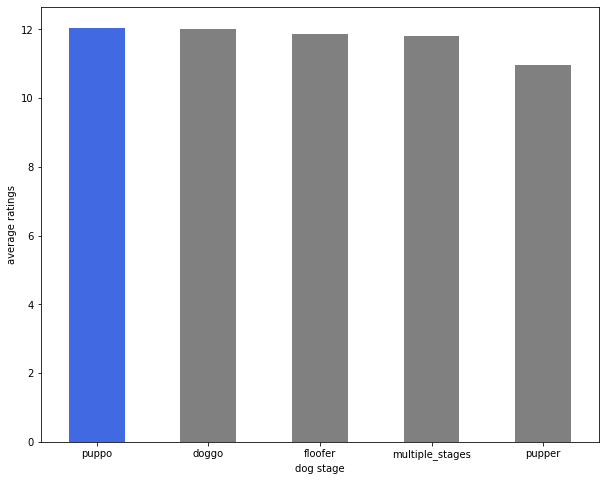

In [79]:
# visualizing the resulting table above in a bar chart
colors = ['royalblue','grey','grey','grey','grey']
ax = rt_df.plot(
             kind='bar',
             x='dog_stage',
             y='rating_numerator',
             figsize=(10,8),
             color=colors,
             rot=0,
             legend=False
              )
ax.set_xlabel('dog stage')
ax.set_ylabel('average ratings');

Dogs in the puppo stage received the highest ratings followed by doggo stage.

##### Dog stage and Favorite count

In [46]:
# grouping mean favorite count by stage
fc_df = master_df.groupby('dog_stage',
        as_index=False)['favorite_count'].mean(
        ).sort_values('favorite_count',ascending=False)
fc_df

,dog_stage,favorite_count
4,puppo,21372.150000
0,doggo,18909.872340
2,multiple_stages,15701.400000
1,floofer,11620.250000
3,pupper,6960.452055


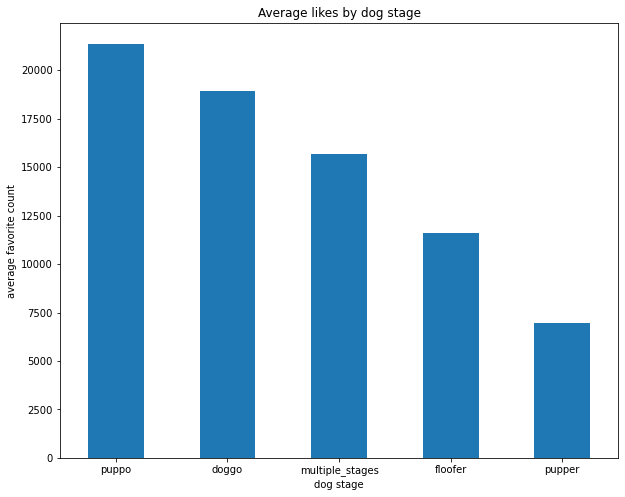

In [98]:
# visualizing the resulting table above in a bar chart
ax = fc_df.plot(
        kind='bar',
        x = 'dog_stage',
        y = 'favorite_count',
        title='Average likes by dog stage',
        figsize=(10,8),
        legend=False,
        rot=0
         )
ax.set_xlabel('dog stage')
ax.set_ylabel('average favorite count');

On the average, tweets with dogs in the `puppo` stage are the most favorited while tweets with dogs in the `pupper` stage are the least favorited 

##### Dog stage and retweet count

In [50]:
# grouping mean retweet count by stage
rc_df = master_df.groupby('dog_stage',
        as_index=False)['retweet_count'].mean(
        ).sort_values('retweet_count',ascending=False)
rc_df

,dog_stage,retweet_count
0,doggo,6395.106383
4,puppo,5919.900000
2,multiple_stages,4667.400000
1,floofer,3809.250000
3,pupper,2061.027397


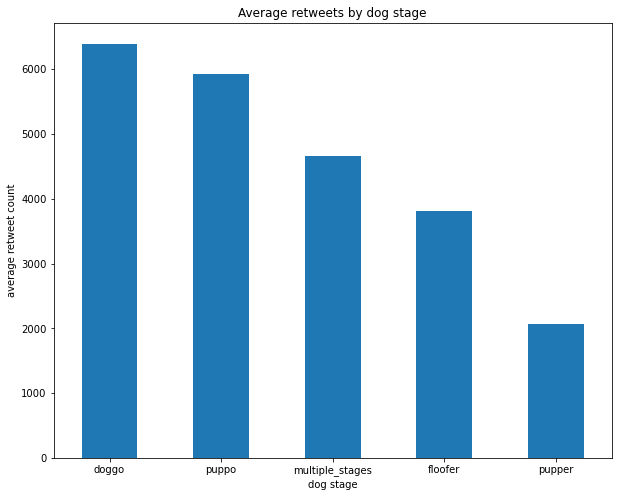

In [97]:
# visualizing the above table in a bar chart
ax = rc_df.plot(
        kind='bar',
        x='dog_stage',
        y='retweet_count',
        title='Average retweets by dog stage',
        figsize=(10,8),
        legend=False,
        rot=0)
ax.set_xlabel('dog stage')
ax.set_ylabel('average retweet count');

Dogs of the `doggo` stage average the most retweets while dogs of the `pupper` stage average the least retweets.

In [94]:
# creating a pivot table
pivot = pd.pivot_table(data=master_df,
                       index='dog_stage',
                       values=['favorite_count','retweet_count']
                      ).sort_values(['favorite_count','retweet_count'],ascending=False)
pivot

,favorite_count,retweet_count
dog_stage,,
puppo,21372.150000,5919.900000
doggo,18909.872340,6395.106383
multiple_stages,15701.400000,4667.400000
floofer,11620.250000,3809.250000
pupper,6960.452055,2061.027397


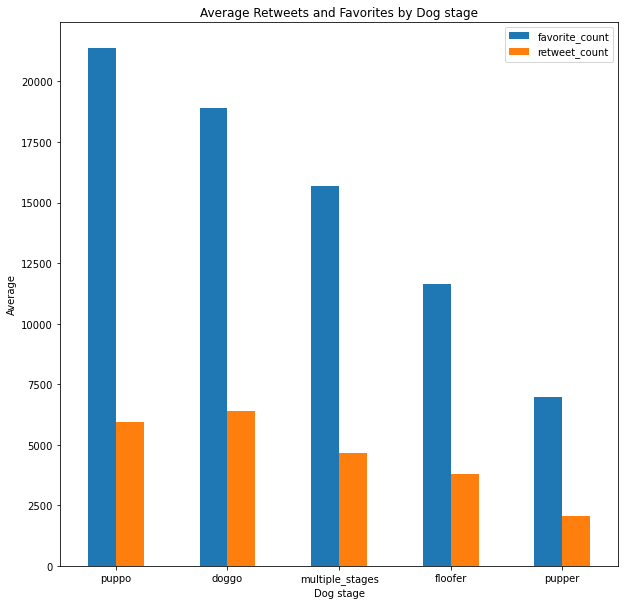

In [96]:
# plotting pivot table on a bar chart
ax = pivot.plot(kind='bar',
                title = 'Average Retweets and Favorites by Dog stage',
                figsize=(10,10),
                rot=0)
ax.set_xlabel('Dog stage')
ax.set_ylabel('Average');

##### Image number and rating

During data cleaning, I discovered an interesting tweet by WeRateDogs and decided to investigate.

In [153]:
# displaying tweet with the interesting observation
df.query('tweet_id == 863427515083354112').text.tolist()

["@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10"]

As the denominators were not equal, I decided to perform this analysis by converting the rating into decimals and using the mean.

In [81]:
# creating new column by dividing rating numerator by denominator
master_df['rating_decimal'] = master_df['rating_numerator']/master_df['rating_denominator']

In [155]:
master_df.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,dog_stage,img_num,p1,p1_conf,retweet_count,favorite_count,rating_decimal
0,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,13.0,10,NaN,1,chihuahua,0.323581,5267,29208,1.3
1,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,NaN,1,chihuahua,0.716012,3463,21959,1.2
2,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,12.0,10,NaN,2,basset,0.555712,7709,35120,1.2
3,891087950875897856,2017-07-29 00:08:17+00:00,Here we have a majestic great white breaching ...,13.0,10,NaN,1,chesapeake_bay_retriever,0.425595,2583,17734,1.3
4,890971913173991426,2017-07-28 16:27:12+00:00,Meet Jax. He enjoys ice cream so much he gets ...,13.0,10,NaN,1,appenzeller,0.341703,1645,10322,1.3


In [85]:
# grouping mean rating by image number
rd_df = master_df.groupby('img_num',as_index=False)['rating_decimal'].mean(
        ).sort_values('rating_decimal',ascending=False)
rd_df

,img_num,rating_decimal
3,4,1.240000
2,3,1.202222
1,2,1.144000
0,1,1.079373


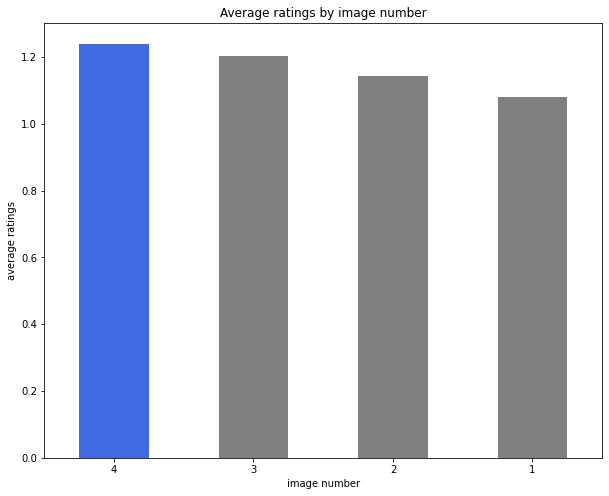

In [89]:
# visualizing the table above in a bar chart
ax  = rd_df.plot(
        kind='bar',
        x='img_num',
        y='rating_decimal',
        title='Average ratings by image number',
        figsize=(10,8),
        color=['royalblue','grey','grey','grey'],
        legend=False,
        rot=0
        )
ax.set_xlabel('image number')
ax.set_ylabel('average ratings');

I discovered that on the average, tweets with four images received higher ratings. I wanted to investigate this further.

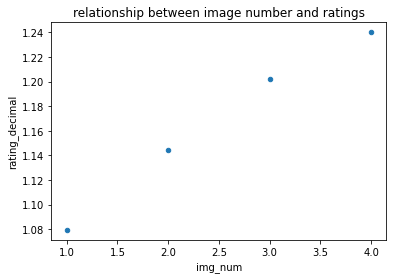

In [158]:
# plotting a scatter graph of the table above
scatter_df = master_df.groupby('img_num',as_index=False)['rating_decimal'].mean().copy()
scatter_df.plot.scatter(
        x='img_num',
        y='rating_decimal',
        title='relationship between image number and ratings'
        );

I discovered that the higher the image number the higher the average ratings. Perhaps because with more images WeRateDogs could 'polish a full analysis'.

### Dog breed analysis

NB: the dog breeds are based on the image prediction algorithm used by Udacity

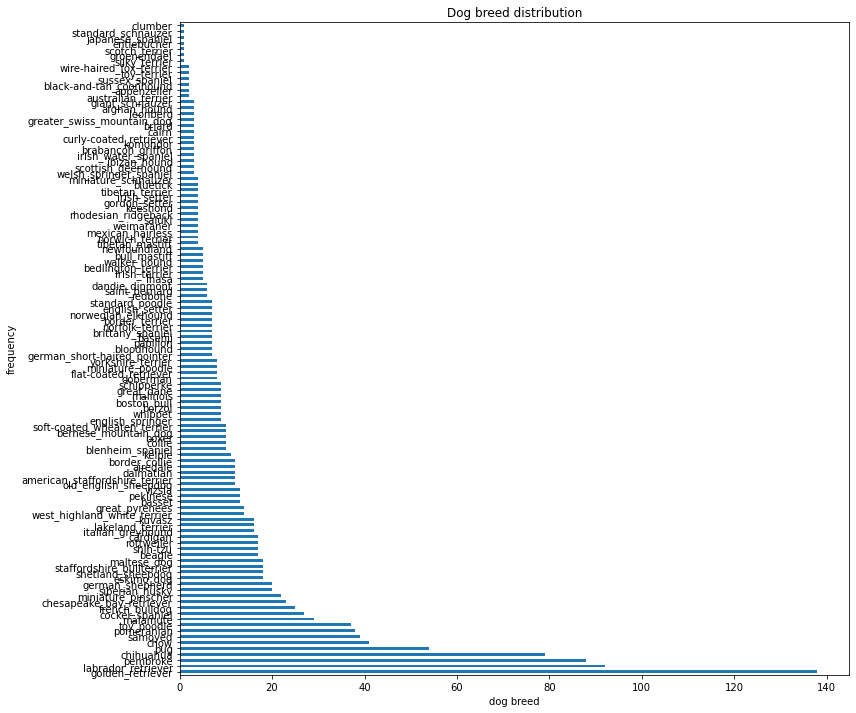

In [4]:
# plotting distribution of dog breeds
ax = master_df.p1.value_counts().plot.barh(
        title='Dog breed distribution',
        figsize=(12,12),
        rot=0)
ax.set_xlabel('dog breed')
ax.set_ylabel('frequency');

The graph is not clear therefore I decided to plot the top 10 dog breeds

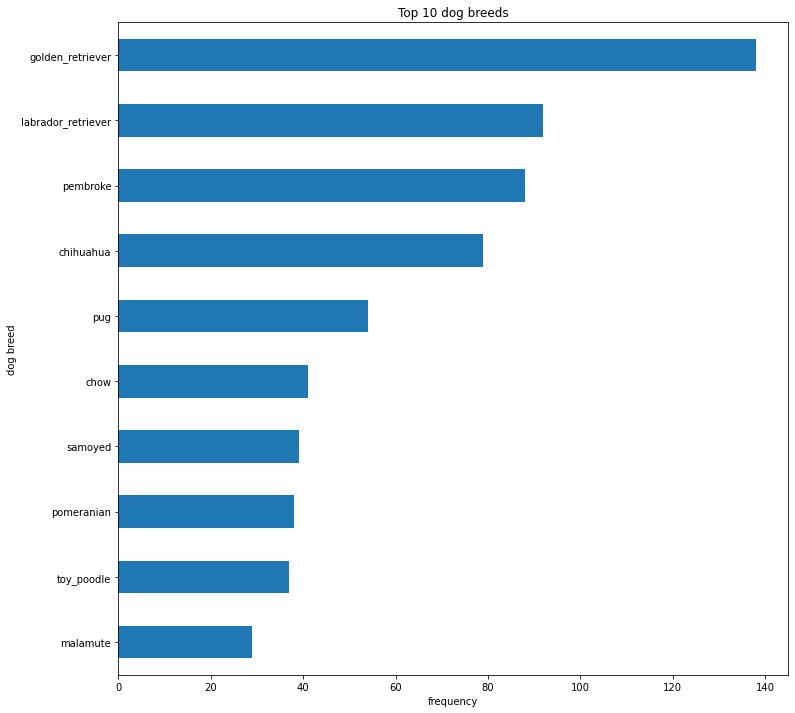

In [78]:
# plottiing top 10 dog breeds by frequency
freq = master_df.p1.value_counts().nlargest(10).sort_values(ascending=True)
ax = freq.plot.barh(
        title='Top 10 dog breeds',
        figsize=(12,12),
        rot=0)
ax.set_xlabel('frequency')
ax.set_ylabel('dog breed');

The most occuring dog breed was the golden retriever followed by the labrador retriever.

### Text Analysis

In [161]:
# importing libraries
from wordcloud import WordCloud
import imageio
from PIL import Image

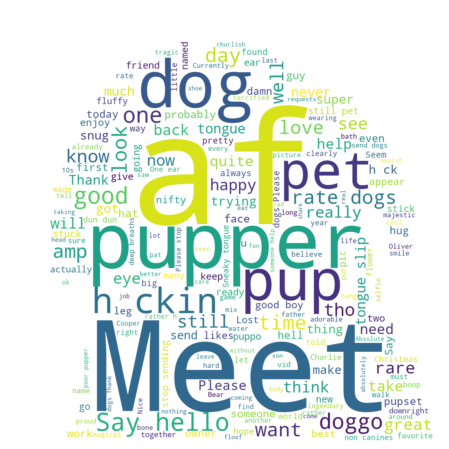

In [162]:
# assigning tweets without http tag to variable 
text = ''.join(master_df.text.str.split(pat='http',expand=True)[0])
# creating a mask using a copy of WeRateDogs twitter avi
weratedogs_mask = imageio.imread('preview.png')
# generating wordcloud
wordcloud = WordCloud(
                    background_color='white',
                    mask=weratedogs_mask
                    ).generate(text)
# displaying wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<a id='insights'></a>
## Insights:
* Dogs of puppo stage received the highest ratings
* Tweets with four images averaged the highest ratings
* Dogs of puppo stage were the most favorited
* Dogs of doggo stage were the most retweeted

### Limitations
Only rows and columns relevant to my analysis were cleaned therefore there may be other quality issues in the master dataframe and individual dataframes that were not cleaned because cleaning them would have no impact on the analysis.

Using the independent variables (image number and dog stage) in predicting ratinsg will require more in-depth analysis and application of machine learning models.

<a id='wranglereport'></a>
## Wrangle Report

#### Report on Data Wrangling performed on WeRateDogs twitter archive.

##### Gathering
I manually downloaded the WeRateDogs twitter archive given by Udacity, moved it into my project directory and imported it into a pandas Dataframe named `df` using the read_csv() function.

I programmatically downloaded the second file hosted on Udacity servers using the Requests library. Then I imported it into a DataFrame named `df_02` using the read_csv() function with the appropriate separator (\t) because it was a tsv file.
Using the Tweepy library, I read each tweet’s json data into a file named tweet_json.txt. Then I imported the contents into an initial DataFrame from which I created another DataFrame named `df_03` containing just the columns I needed for my analysis.

##### Assessing and Cleaning
I assessed the three dataframes visually and programmatically and listed the quality and tidiness issues I discovered. Below is a list of the issues and how I cleaned them.

##### Issue:

* Double dog stages instead of one
* Wrong rating numerator and denominator
* Tweets with ratings that were not dog ratings

During my assessment, I discovered that double dog stages ahd been extracted from some tweets. While this was correct for some because there was more than one dog in the tweet, for some another dog stage had just been mentioned in the tweet but not as the stage of the dog in the tweet. Using the index of tweets in this category, I replaced the wrong dog stages with ‘None’
I also discovered that some rating numerators and denominators had been extracted wrongly therefore I manually replaced them with the correct figures.
For tweets with ratings that I discovered were not dogs, I dropped them using the index.

##### Issue: 

* `df` DataFrame contains retweets

Tweets that contained non null values in the ‘retweeted_status_id’ column were retweets therefore I dropped all of such tweets. This in turn deleted the non nulls in the ‘retweeted_status_user_id’ and ‘retweeted_status_timestamp’ columns.

##### Issue: 

* row values in multiple columns(`doggo`,`pupper`,`floofer`,`puppo`)

These columns belonged in one column because they were dog stages. I replaced ‘None’ in the columns with an empty string and used string concatenation to merge the columns into one. For tweets that had more than one dog stage, I changed it to ‘multiple_stages’.

##### Issues: 

* data type of `timestamp` column is string instead of datetime

I used pandas to_datetime() function to convert the timestamp column’s data type to datetime format. 

##### Issues:

* Missing values in the `in_reply_to_status_id` column

* Missing values in the `in_reply_to_user_id` column

* HTML tag in the `source` column

* Missing values in the `retweeted_status_id` column

* Missing values in the `retweeted_status_timestamp` column

* Missing values represented as `None` in the `name` column

* Missing values in the `expanded_urls` column

These columns were not relevant to my analysis and visualizations therefore I dropped them.

##### Issue:

* Some values in the `p1`, `p2` and `p3` columns are capitalized while others are not

I used .str.lower() to convert the values in these columns to lowercase.

##### Issue: 

* the confidence level of the second (`p2_conf`) and third (`p3_conf`) algorithms are relatively lower than the 1st algorithm(`p1_conf`)

I dropped these columns leaving the first alogorithm.

##### Issue: 

* According to the p1 algorithm some tweets are not dogs hence `False` in the `p1_dog` column

I filtered for rows that were false in the p1_dog column and dropped them after which I dropped the p1_dog column because it only contained True.

##### Issue:

* tweet IDs column is labeled as `id`

I renamed the id column to ‘tweet_id’

##### Issue:

* information about one observational unit (tweets) is contained in the 3 different dataframes

After cleaning, I merged the three dataframes into one using the observational unit (`tweet_id`) 
